This Jupyter notebook contains the code for 3 parts:  
1. Web Scraping of Points and Team Statistics  
2. Data Clean  
3. Data Analysis  
  1) Simple Linear Regression  
  2) Linear Regression with Regularization  
  3) Features Selection  
  4) Visualization of Final Model  

In [2]:
#load packages
from __future__ import print_function, division
import pandas as pd
import numpy as np
import requests
import pickle
from pandas.core import datetools

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
import time
import math

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from selenium import webdriver
from selenium.webdriver.common.keys import Keys

%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [4]:
%run web_scraping.py
%run regularization_functions.py

# 1. Web Scraping of Points and Team Statistics

In [4]:
#from bs4 import BeautifulSoup as soup

In [5]:
#start web scraping Laliga season points on the website of https://www.whoscored.com/
chromedriver_path = "/Users/Tong/chromedriver"
driver = webdriver.Chrome(chromedriver_path)
driver.get('https://www.whoscored.com/')
time.sleep(5); 

In [6]:
#select the league Laliga on the website
Laliga_click(driver) 

In [6]:
Raw_Point_Results = pd.DataFrame(columns = ['season','team', 'points'])

In [10]:
for season_num in range(1,8):
    Raw_Point_Results = Raw_Point_Results.append(Season_Point_Results(driver, season_num))

season: 2010 - 2011
season: 2011 - 2012
season: 2012 - 2013
season: 2013 - 2014
season: 2014 - 2015
season: 2015 - 2016
season: 2016 - 2017


In [11]:
#pickle.dump(Raw_Point_Results, open('data/Point Results Raw Data.p', 'wb'))

In [12]:
Raw_Point_Results = Raw_Point_Results.reset_index(drop = True)
Raw_Point_Results.head()

,season,team,points
0,2010 - 2011,Barcelona,96
1,2010 - 2011,Real Madrid,92
2,2010 - 2011,Valencia,71
3,2010 - 2011,Villarreal,62
4,2010 - 2011,Sevilla,58


In [20]:
Raw_Summary_Overall_Statistic = pd.DataFrame(columns = ['season', 'R', 'team','shots_pg', 'discipline_yellow', 'discipline_red', 'possession', 'pass_success', 'aerials_won', 'rating'])
for season_num in range(1,8):
    Raw_Summary_Overall_Statistic = Raw_Summary_Overall_Statistic.append(Season_Team_Statistics(driver, season_num, 'summary'))

In [21]:
Raw_Summary_Overall_Statistic = Raw_Summary_Overall_Statistic.reset_index(drop = True)

In [23]:
#pickle.dump(Raw_Summary_Overall_Statistic, open('data/Summary Overall Statistic Raw Data.p', 'wb'))

In [24]:
#Get defensive stats for teams.
Raw_Defensive_Overall_Statistic = pd.DataFrame(columns = ['season', 'R', 'team','shots_pg', 'tackles_pg', 'interceptions_pg', 'fouls_pg', 'offsides_pg', 'rating'])
for season_num in range(1,8):
    Raw_Defensive_Overall_Statistic = Raw_Defensive_Overall_Statistic.append(Season_Team_Statistics(driver, season_num, 'defensive'))

In [26]:
#pickle.dump(Raw_Defensive_Overall_Statistic, open('data/Defensive Overall Statistic Raw Data.p', 'wb'))

In [27]:
Get offensive stats for teams.
Raw_Offensive_Overall_Statistic = pd.DataFrame(columns = ['season', 'R', 'team','shots_pg', 'shots_ot_pg', 'dribbles_pg', 'fouled_pg', 'rating'])
for season_num in range(1,8):
    Raw_Offensive_Overall_Statistic = Raw_Offensive_Overall_Statistic.append(Season_Team_Statistics(driver, season_num, 'offensive'))

In [28]:
#pickle.dump(Raw_Offensive_Overall_Statistic, open('data/Offensive Overall Statistic Raw Data.p', 'wb'))

# 2. Data Clean

In [15]:
Point_Results = pickle.load(open('data/Point Results Raw Data.p', 'rb'))

In [16]:
Point_Results.head()

,season,team,points
0,2010 - 2011,Barcelona,96
1,2010 - 2011,Real Madrid,92
2,2010 - 2011,Valencia,71
3,2010 - 2011,Villarreal,62
4,2010 - 2011,Sevilla,58


In [17]:
Summary_Statistic = pickle.load(open('data/Summary Overall Statistic Raw Data.p', 'rb'))
Defensive_Statistic = pickle.load(open('data/Defensive Overall Statistic Raw Data.p', 'rb'))
Offensive_Statistic = pickle.load(open('data/Offensive Overall Statistic Raw Data.p', 'rb'))

In [18]:
Summary_Statistic.head()

,season,team,shots_pg,discipline_yellow,discipline_red,possession,pass_success,aerials_won
0,2010 - 2011,Barcelona,15.8,71,2,67.4,89.6,6.2
1,2010 - 2011,Real Madrid,19.1,94,7,55.0,82.9,10.1
2,2010 - 2011,Valencia,13.1,112,8,54.6,80.0,11.8
3,2010 - 2011,Villarreal,13.9,88,5,52.7,82.2,7.8
4,2010 - 2011,Atletico Madrid,15.1,106,5,49.9,76.6,10.7


In [19]:
Defensive_Statistic.head()

,season,R,team,shots_pg,tackles_pg,interceptions_pg,fouls_pg,offsides_pg,rating
0,2010 - 2011,1,Barcelona,7.4,18.5,18.2,10.6,3.9,7.21
0,2010 - 2011,2,Real Madrid,10.2,22.4,21.8,14.2,3.8,7.20
0,2010 - 2011,3,Valencia,13.4,19.2,23.3,16,2.8,6.97
0,2010 - 2011,4,Villarreal,12,22.8,24.6,12.4,2.2,6.95
0,2010 - 2011,5,Atletico Madrid,13.6,21.7,22.2,14.8,2.5,6.89


Remove non-statistics

In [20]:
Defensive_Statistic = Defensive_Statistic.drop('R', axis = 1)
Defensive_Statistic = Defensive_Statistic.drop('rating', axis = 1)
Defensive_Statistic = Defensive_Statistic.reset_index(drop = True)
Defensive_Statistic.rename(columns = {'shots_pg': 'shots_conceded_pg'}, inplace = True)

In [21]:
Defensive_Statistic.head()

,season,team,shots_conceded_pg,tackles_pg,interceptions_pg,fouls_pg,offsides_pg
0,2010 - 2011,Barcelona,7.4,18.5,18.2,10.6,3.9
1,2010 - 2011,Real Madrid,10.2,22.4,21.8,14.2,3.8
2,2010 - 2011,Valencia,13.4,19.2,23.3,16,2.8
3,2010 - 2011,Villarreal,12,22.8,24.6,12.4,2.2
4,2010 - 2011,Atletico Madrid,13.6,21.7,22.2,14.8,2.5


Remove non-statistics and duplicated columns

In [22]:
Offensive_Statistic  = Offensive_Statistic.drop('R', axis = 1)
Offensive_Statistic  = Offensive_Statistic.drop('rating', axis = 1)
Offensive_Statistic  = Offensive_Statistic.drop('shots_pg', axis = 1)
Offensive_Statistic = Offensive_Statistic.reset_index(drop = True)
Offensive_Statistic.head()

,season,team,shots_ot_pg,dribbles_pg,fouled_pg
0,2010 - 2011,Barcelona,7.3,14.7,13.4
1,2010 - 2011,Real Madrid,8,11.7,13.7
2,2010 - 2011,Valencia,5.1,7.9,12.1
3,2010 - 2011,Villarreal,5.4,9.2,16.4
4,2010 - 2011,Atletico Madrid,5.7,7.6,14.9


In [23]:
Statistics = pd.merge(Summary_Statistic, Defensive_Statistic, on=['season', 'team'], how='right')
Statistics = pd.merge(Statistics, Offensive_Statistic, on=['season', 'team'], how='right')

In [24]:
Statistics.head()

,season,team,shots_pg,discipline_yellow,discipline_red,possession,pass_success,aerials_won,shots_conceded_pg,tackles_pg,interceptions_pg,fouls_pg,offsides_pg,shots_ot_pg,dribbles_pg,fouled_pg
0,2010 - 2011,Barcelona,15.8,71,2,67.4,89.6,6.2,7.4,18.5,18.2,10.6,3.9,7.3,14.7,13.4
1,2010 - 2011,Real Madrid,19.1,94,7,55.0,82.9,10.1,10.2,22.4,21.8,14.2,3.8,8,11.7,13.7
2,2010 - 2011,Valencia,13.1,112,8,54.6,80.0,11.8,13.4,19.2,23.3,16,2.8,5.1,7.9,12.1
3,2010 - 2011,Villarreal,13.9,88,5,52.7,82.2,7.8,12,22.8,24.6,12.4,2.2,5.4,9.2,16.4
4,2010 - 2011,Atletico Madrid,15.1,106,5,49.9,76.6,10.7,13.6,21.7,22.2,14.8,2.5,5.7,7.6,14.9


In [25]:
Points_Statistics_df = pd.merge(Point_Results, Statistics, on=['season', 'team'], how='right')

In [26]:
Points_Statistics_df.head()

,season,team,points,shots_pg,discipline_yellow,discipline_red,possession,pass_success,aerials_won,shots_conceded_pg,tackles_pg,interceptions_pg,fouls_pg,offsides_pg,shots_ot_pg,dribbles_pg,fouled_pg
0,2010 - 2011,Barcelona,96,15.8,71,2,67.4,89.6,6.2,7.4,18.5,18.2,10.6,3.9,7.3,14.7,13.4
1,2010 - 2011,Real Madrid,92,19.1,94,7,55.0,82.9,10.1,10.2,22.4,21.8,14.2,3.8,8,11.7,13.7
2,2010 - 2011,Valencia,71,13.1,112,8,54.6,80.0,11.8,13.4,19.2,23.3,16,2.8,5.1,7.9,12.1
3,2010 - 2011,Villarreal,62,13.9,88,5,52.7,82.2,7.8,12,22.8,24.6,12.4,2.2,5.4,9.2,16.4
4,2010 - 2011,Sevilla,58,13.8,100,7,52.7,80.1,13.7,12.6,19.3,20.4,14.5,2.2,5.5,7.7,14.9


In [29]:
to_numeric_columns = ['points', 'shots_pg', 'discipline_yellow',
       'discipline_red', 'possession', 'pass_success', 'aerials_won',
       'shots_conceded_pg', 'tackles_pg', 'interceptions_pg', 'fouls_pg',
       'offsides_pg', 'shots_ot_pg', 'dribbles_pg', 'fouled_pg']
for column in to_numeric_columns:
    Points_Statistics_df[column] = pd.to_numeric(Points_Statistics_df[column])

In [31]:
#pickle.dump(Points_Statistics_df, open('data/Points_Statistics_df.p', 'wb'))

# 3. Data Analysis

In [32]:
Points_Statistics_df = pickle.load(open('data/Points_Statistics_df.p', 'rb'))

In [33]:
Points_Statistics_df = Points_Statistics_df.drop(['team', 'season'], axis = 1)

In [34]:
Points_Statistics_df.head()

,points,shots_pg,discipline_yellow,discipline_red,possession,pass_success,aerials_won,shots_conceded_pg,tackles_pg,interceptions_pg,fouls_pg,offsides_pg,shots_ot_pg,dribbles_pg,fouled_pg
0,96,15.8,71,2,67.4,89.6,6.2,7.4,18.5,18.2,10.6,3.9,7.3,14.7,13.4
1,92,19.1,94,7,55.0,82.9,10.1,10.2,22.4,21.8,14.2,3.8,8.0,11.7,13.7
2,71,13.1,112,8,54.6,80.0,11.8,13.4,19.2,23.3,16.0,2.8,5.1,7.9,12.1
3,62,13.9,88,5,52.7,82.2,7.8,12.0,22.8,24.6,12.4,2.2,5.4,9.2,16.4
4,58,13.8,100,7,52.7,80.1,13.7,12.6,19.3,20.4,14.5,2.2,5.5,7.7,14.9


Normalize all features for regularization.

In [35]:
columns = Points_Statistics_df.columns
X = Points_Statistics_df.drop(['points'], axis = 1) 
y = Points_Statistics_df[['points']]
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X))
Points_Statistics_df = pd.concat([y, X_scaled], axis=1)
Points_Statistics_df.columns = columns

Look at the correlations between the final team points with diffrent variables

In [36]:
Points_Statistics_df.corr().sort_values('points')

,points,shots_pg,discipline_yellow,discipline_red,possession,pass_success,aerials_won,shots_conceded_pg,tackles_pg,interceptions_pg,fouls_pg,offsides_pg,shots_ot_pg,dribbles_pg,fouled_pg
shots_conceded_pg,-0.636550,-0.455999,0.375049,0.289173,-0.564062,-0.506937,0.112322,1.000000,0.057106,0.309091,0.353280,-0.287218,-0.538155,-0.540689,-0.111676
discipline_yellow,-0.483785,-0.333550,1.000000,0.441729,-0.438955,-0.529490,0.145392,0.375049,0.228712,0.293482,0.740530,-0.178330,-0.451294,-0.444416,-0.006553
fouls_pg,-0.447149,-0.400628,0.740530,0.356949,-0.552007,-0.644460,0.272430,0.353280,0.277587,0.314656,1.000000,-0.149707,-0.479082,-0.546391,-0.178470
discipline_red,-0.370104,-0.132238,0.441729,1.000000,-0.228531,-0.283500,0.116775,0.289173,0.156889,0.220819,0.356949,-0.142730,-0.250165,-0.335623,0.059555
aerials_won,-0.327054,-0.397959,0.145392,0.116775,-0.467095,-0.555623,1.000000,0.112322,-0.009988,-0.239704,0.272430,-0.377915,-0.474952,-0.361278,-0.349827
interceptions_pg,-0.230981,-0.123078,0.293482,0.220819,-0.252960,-0.352741,-0.239704,0.309091,0.477674,1.000000,0.314656,0.102373,-0.172496,-0.495694,0.070736
tackles_pg,0.016435,0.036475,0.228712,0.156889,-0.130876,-0.191562,-0.009988,0.057106,1.000000,0.477674,0.277587,0.118622,-0.030039,-0.275303,0.167338
fouled_pg,0.235595,0.307255,-0.006553,0.059555,0.394211,0.384467,-0.349827,-0.111676,0.167338,0.070736,-0.178470,0.161226,0.308641,0.205582,1.000000
offsides_pg,0.534218,0.583614,-0.178330,-0.142730,0.495478,0.423935,-0.377915,-0.287218,0.118622,0.102373,-0.149707,1.000000,0.636384,0.235657,0.161226
dribbles_pg,0.585084,0.524475,-0.444416,-0.335623,0.683674,0.764941,-0.361278,-0.540689,-0.275303,-0.495694,-0.546391,0.235657,0.605890,1.000000,0.205582


Several features are highlly correlated with each other, such as shots_pg with shots_og_pg, discipline_yellow with fouls_pg and possession with pass_success. 

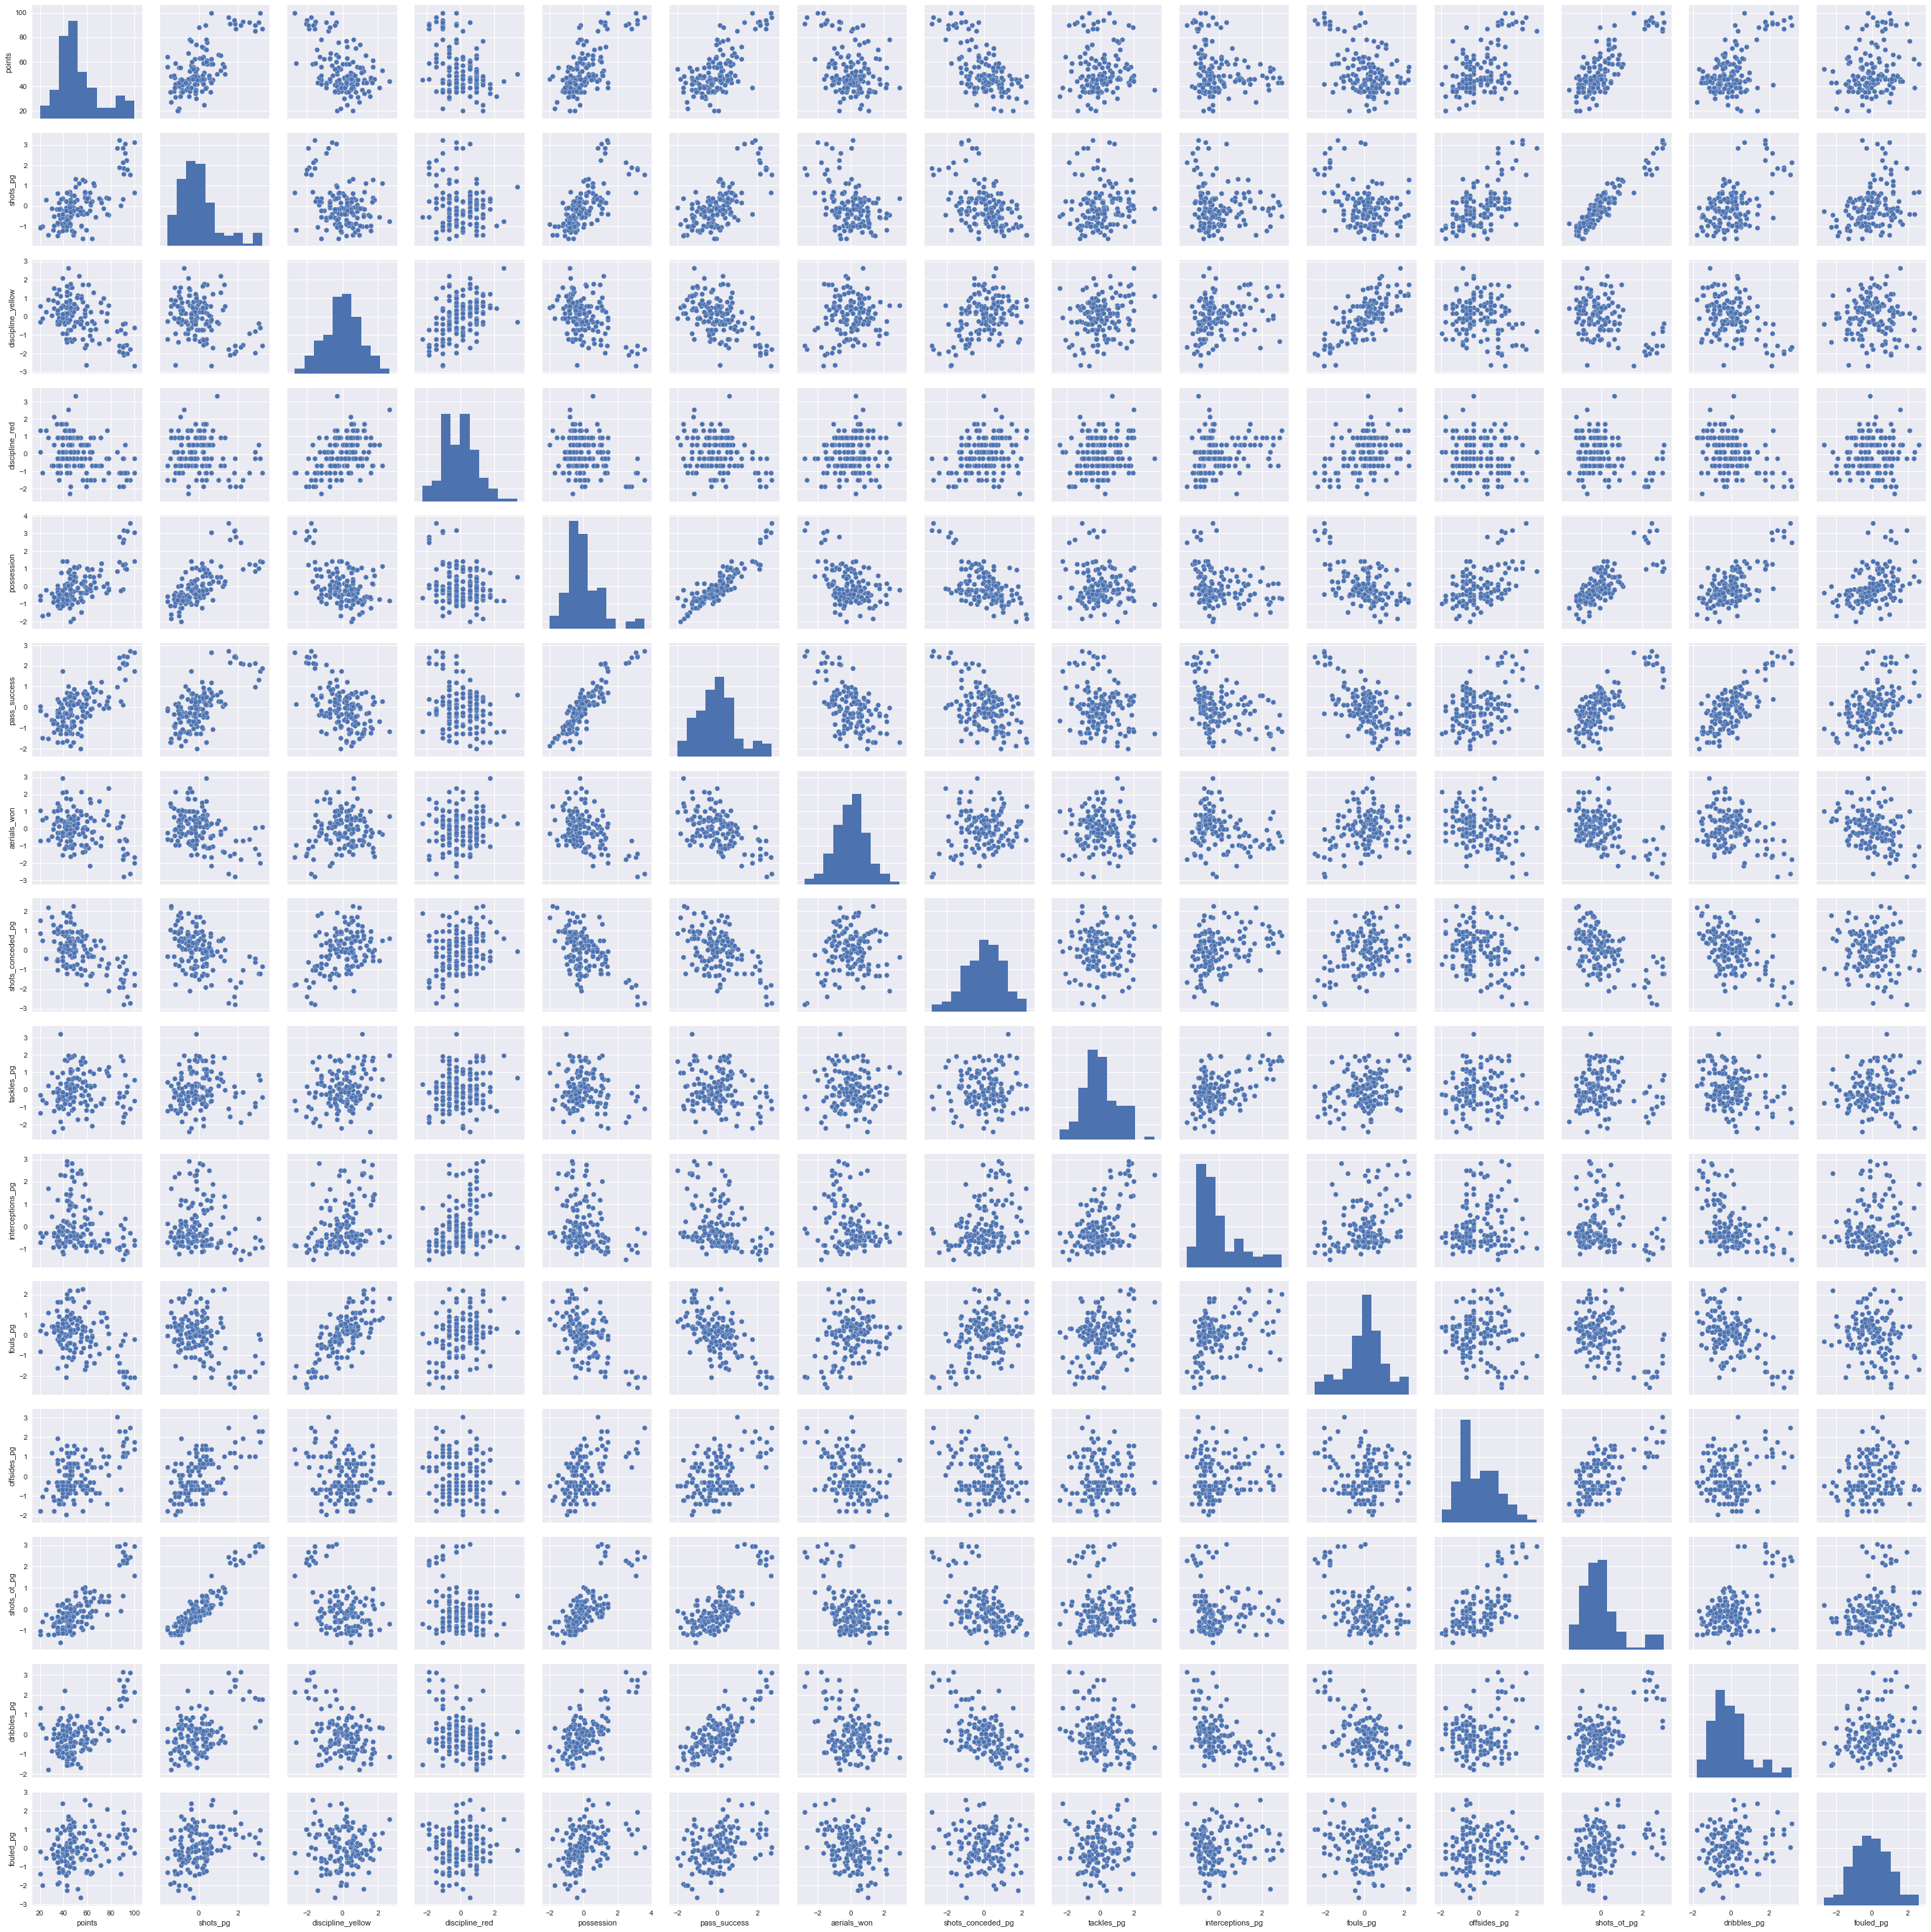

In [37]:
sns.pairplot(Points_Statistics_df);

### 1) Simple Linear Regression

We first have a look at the linear regression results for team points with all the features that have correlations over 0.1.

In [38]:
lm1 = smf.ols('points ~ shots_pg + discipline_yellow + discipline_red + possession + pass_success + aerials_won + shots_conceded_pg + interceptions_pg + fouls_pg + offsides_pg + shots_ot_pg + dribbles_pg+ fouled_pg', data=Points_Statistics_df)
fit1 = lm1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 points   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     31.36
Date:                Wed, 27 Sep 2017   Prob (F-statistic):           2.67e-33
Time:                        19:44:23   Log-Likelihood:                -502.41
No. Observations:                 140   AIC:                             1033.
Df Residuals:                     126   BIC:                             1074.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            52.6000      0.780     67.435      0.000      51.056      54.144
shots_pg             -6.2733      2.446     -2.565      0.011     -11.113      -1.434
discipline_yellow    -0.6403      1.313     -0.488      0.627      -3.239       1.958
discipline_red       -1.7648      0.915     -1.928      0.056      -3.576       0.047
possession           -3.1988      2.003     -1.597      0.113      -7.162       0.764
pass_success          6.3606      2.508      2.536      0.012       1.398      11.323
aerials_won           2.8538      1.249      2.285      0.024       0.383       5.325
shots_conceded_pg    -4.0451      1.058     -3.824      0.000      -6.139      -1.952
interceptions_pg      1.3642      1.154      1.183      0.239      -0.919       3.647
fouls_pg              1.3025      1.331      0.979      0.330      -1.331       3.936
offsides_pg           1.2783      1.107      1.155      0.250      -0.913       3.470
shots_ot_pg          16.2951      3.007      5.419      0.000      10.345      22.246
dribbles_pg           0.2355      1.396      0.169      0.866      -2.527       2.998
fouled_pg             0.4883      0.913      0.535      0.594      -1.319       2.296
==============================================================================
Omnibus:                        0.216   Durbin-Watson:                   1.462
Prob(Omnibus):                  0.898   Jarque-Bera (JB):                0.100
Skew:                           0.065   Prob(JB):                        0.951
Kurtosis:                       3.020   Cond. No.                         11.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared: 0.764  pretty good, the model can explain 76.4% variance of the final points  
adj R-squared: 0.740  good  

Try removing the top three features with the hightes p value: 'dribbles_pg', discipline_yellow' and 'fouled_pg' and see if that improves adj R-squared.

In [39]:
lm2 = smf.ols('points ~ shots_pg + discipline_red + possession + pass_success + aerials_won + shots_conceded_pg + interceptions_pg + fouls_pg + offsides_pg + shots_ot_pg', data=Points_Statistics_df)
fit2 = lm2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 points   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     41.55
Date:                Wed, 27 Sep 2017   Prob (F-statistic):           1.33e-35
Time:                        19:45:13   Log-Likelihood:                -502.66
No. Observations:                 140   AIC:                             1027.
Df Residuals:                     129   BIC:                             1060.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            52.6000      0.772     68.110      0.000      51.072      54.128
shots_pg             -6.4889      2.363     -2.746      0.007     -11.164      -1.814
discipline_red       -1.8165      0.878     -2.069      0.041      -3.553      -0.080
possession           -3.1890      1.952     -1.634      0.105      -7.050       0.672
pass_success          6.7491      2.370      2.847      0.005       2.059      11.439
aerials_won           2.9047      1.190      2.440      0.016       0.550       5.260
shots_conceded_pg    -4.0702      1.022     -3.983      0.000      -6.092      -2.048
interceptions_pg      1.4252      1.064      1.339      0.183      -0.680       3.530
fouls_pg              0.9410      1.070      0.879      0.381      -1.176       3.058
offsides_pg           1.1912      1.079      1.104      0.272      -0.943       3.325
shots_ot_pg          16.6661      2.881      5.785      0.000      10.966      22.366
==============================================================================
Omnibus:                        0.180   Durbin-Watson:                   1.468
Prob(Omnibus):                  0.914   Jarque-Bera (JB):                0.072
Skew:                           0.055   Prob(JB):                        0.965
Kurtosis:                       3.016   Cond. No.                         10.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The removal of three high-p-value features does improve adj R-squared from 0.740 to 0.745.

Try removing another two features with the hightes p value: 'fouls_pg' and offsides_pg', and see if that improves adj R-squared.

In [40]:
lm3 = smf.ols('points ~ shots_pg + discipline_red + possession + pass_success + aerials_won + shots_conceded_pg + interceptions_pg + shots_ot_pg', data = Points_Statistics_df)
fit3 = lm3.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 points   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     51.47
Date:                Wed, 27 Sep 2017   Prob (F-statistic):           8.35e-37
Time:                        19:45:44   Log-Likelihood:                -503.96
No. Observations:                 140   AIC:                             1026.
Df Residuals:                     131   BIC:                             1052.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            52.6000      0.774     68.000      0.000      51.070      54.130
shots_pg             -6.5757      2.356     -2.792      0.006     -11.236      -1.916
discipline_red       -1.6850      0.858     -1.963      0.052      -3.383       0.013
possession           -2.7295      1.928     -1.416      0.159      -6.543       1.084
pass_success          5.6759      2.228      2.547      0.012       1.268      10.083
aerials_won           2.7383      1.185      2.311      0.022       0.394       5.082
shots_conceded_pg    -4.0196      1.021     -3.936      0.000      -6.040      -1.999
interceptions_pg      1.6361      1.050      1.559      0.121      -0.440       3.713
shots_ot_pg          17.5381      2.735      6.412      0.000      12.127      22.949
==============================================================================
Omnibus:                        0.160   Durbin-Watson:                   1.472
Prob(Omnibus):                  0.923   Jarque-Bera (JB):                0.075
Skew:                           0.057   Prob(JB):                        0.963
Kurtosis:                       3.000   Cond. No.                         9.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The removal of another two high-p-value features starts to reduce adj R-squared from 0.745 to 0.744. I'll see if this holds true for regularization with cross validations. 

### 2) Linear Regression with Regularization 

In [41]:
Points_Statistics_df.head()

,points,shots_pg,discipline_yellow,discipline_red,possession,pass_success,aerials_won,shots_conceded_pg,tackles_pg,interceptions_pg,fouls_pg,offsides_pg,shots_ot_pg,dribbles_pg,fouled_pg
0,96,1.525687,-1.763603,-1.478598,3.577273,2.723366,-2.649403,-2.725229,-1.090142,-0.281159,-2.087874,2.495257,2.439424,3.115856,0.050501
1,92,3.038279,-0.356915,0.531147,1.027743,1.337527,-1.510996,-1.221231,0.838625,0.336558,0.031112,2.310129,3.046647,1.762957,0.276146
2,71,0.288113,0.743972,0.933096,0.945500,0.737686,-1.014767,0.497624,-0.743953,0.593940,1.090605,0.458852,0.531010,0.049284,-0.927292
3,62,0.654801,-0.723877,-0.272751,0.554846,1.192738,-2.182364,-0.254375,1.036447,0.817005,-1.028381,-0.651914,0.791248,0.635541,2.306948
4,58,0.608965,0.010048,0.531147,0.554846,0.758370,-0.460158,0.067910,-0.694497,0.096334,0.207694,-0.651914,0.877994,-0.040909,1.178725


Optimize alpha and l1_ratio using elastiicnet regularization

In [42]:
alphas = np.logspace(-5,2,num = 8)

l1_ratios = np.arange(0.01, 1.1, 0.1)

max_score, optimized_alpha, optimized_l1_ratio = elasticnet_optimize_parameters(Points_Statistics_df, alphas, l1_ratios)

print("The maximum score is {:0.4f} when alpha is {} and l1_ratio is {:0.2f}".format(max_score, optimized_alpha, optimized_l1_ratio))

The maximum score is 0.7824 when alpha is 0.1 and l1_ratio is 0.61


Narrow down the ranges and add more points of alpha and l1_ratio to optimize alpha and l1_ratio.

In [43]:
alphas = np.logspace(-3,1,num = 20)

l1_ratios = np.arange(0.01, 1.01, 0.01)

max_score, optimized_alpha, optimized_l1_ratio = elasticnet_optimize_parameters(Points_Statistics_df, alphas, l1_ratios)

print("After the range is narrowed down, the maximum score is {:0.4f} when alpha is {:0.4f} and l1_ratio is {:0.2f}".format(max_score, optimized_alpha, optimized_l1_ratio))

After the range is narrowed down, the maximum score is 0.7901 when alpha is 0.2069 and l1_ratio is 0.99


Further narrow down the ranges and add more points of alpha and l1_ratio to optimize alpha and l1_ratio.

In [44]:
alphas = np.logspace(-1,1,num = 200)

l1_ratios = np.arange(0.5, 1.01, 0.01)

max_score, optimized_alpha, optimized_l1_ratio = elasticnet_optimize_parameters(Points_Statistics_df, alphas, l1_ratios)

print("After the range is further narrowed down, the maximum score is {:0.4f} when alpha is {:0.4f} and l1_ratio is {:0.2f}".format(max_score, optimized_alpha, optimized_l1_ratio))

After the range is further narrowed down, the maximum score is 0.7910 when alpha is 0.2354 and l1_ratio is 1.00


The optimized l1_ratio is 1, indicating the lasso regularization is more appropriate
I'll use lasso regularization for my analysis.

In [45]:
alphas = np.logspace(-1,1,num = 200)

max_score, optimized_alpha = lasso_optimize_alpha(Points_Statistics_df, alphas)

print("After the range is further narrowed down, the maximum score is {:0.4f} when alpha is {:0.4f}.".format(max_score, optimized_alpha))

After the range is further narrowed down, the maximum score is 0.7910 when alpha is 0.2354.


### 3) Features Selection

Preform linear regression with cross validation and lasso regularaization to predict end-of-season points with team statistics.

In [47]:
optimized_alpha = 0.2354

print('score with all features: {:0.4f}'.format(pseudo_cross_val_lasso_score(Points_Statistics_df, 5, optimized_alpha)))

model= Lasso(alpha = optimized_alpha, max_iter=10000)
fit = model.fit(Points_Statistics_df.drop('points', axis = 1), Points_Statistics_df['points'])

print('the coefficients of this model is: {}.'.format(fit.coef_))

score with all features: 0.7910
the coefficients of this model is: [ -2.33525343  -0.67061772  -1.90580921  -0.           2.63255574
   1.04809564  -3.78219383   1.61339672  -0.09478825   0.03072791
   0.93674603  11.68617927   0.027845    -0.        ].


Try to remove the five features with lowest correlation with points: 'tackles_pg', 'interceptions_pg', 'fouled_pg' 'aerials_won', 'discipline_red'.

In [48]:
print('score after removing tackles_pg: {:0.4f}'.format(
    pseudo_cross_val_lasso_score(Points_Statistics_df.drop('tackles_pg', axis = 1), 5, optimized_alpha)))

print('score after removing interceptions_pg: {:0.4f}'.format(
    pseudo_cross_val_lasso_score(Points_Statistics_df.drop('interceptions_pg', axis = 1), 5, optimized_alpha)))

print('score after removing fouled_pg: {:0.4f}'.format(
    pseudo_cross_val_lasso_score(Points_Statistics_df.drop('fouled_pg', axis = 1), 5, optimized_alpha)))

print('score after removing aerials_won: {:0.4f}'.format(
    pseudo_cross_val_lasso_score(Points_Statistics_df.drop('aerials_won', axis = 1), 5, optimized_alpha)))

print('score after removing discipline_red: {:0.4f}'.format(
    pseudo_cross_val_lasso_score(Points_Statistics_df.drop('discipline_red', axis = 1), 5, optimized_alpha)))

score after removing tackles_pg: 0.7663
score after removing interceptions_pg: 0.7910
score after removing fouled_pg: 0.7921
score after removing aerials_won: 0.7832
score after removing discipline_red: 0.7818


The removal of fouled_pg and interceptions_pg increased my prediction accuracy. I'll remove the two features.

In [49]:
Points_Statistics_df_important = Points_Statistics_df.drop(['fouled_pg', 'interceptions_pg'], axis =  1)
print('score after removing less correlated features: {:0.4f}'.format( 
    pseudo_cross_val_lasso_score(Points_Statistics_df_important, 5, optimized_alpha)))

score after removing less correlated features: 0.7926


The pairs of variables having correlations over 0.7 are as following: shots_pg vs shots_ot_pg (corr = 0.935), possession vs pass_success (0.895), possession vs shots_ot_pg (0.764) and pass_success vs shots_ot_pg (0.762).

Try to remove shots_pg, pass_success, shots_ot_pg, possession.

In [50]:
print('score after removing shots_pg: {:0.4f}'.format(
    pseudo_cross_val_lasso_score(Points_Statistics_df_important.drop('shots_pg', axis = 1), 5, optimized_alpha)))

print('score after removing pass_success: {:0.4f}'.format(
    pseudo_cross_val_lasso_score(Points_Statistics_df_important.drop('pass_success', axis = 1), 5, optimized_alpha)))

print('score after removing shots_ot_pg: {:0.4f}'.format(
    pseudo_cross_val_lasso_score(Points_Statistics_df_important.drop('shots_ot_pg', axis = 1), 5, optimized_alpha)))

print('score after removing possession: {:0.4f}'.format(
    pseudo_cross_val_lasso_score(Points_Statistics_df_important.drop('possession', axis = 1), 5, optimized_alpha)))

print('score after removing multiple features: {:0.4f}'.format(
    pseudo_cross_val_lasso_score(Points_Statistics_df_important.drop(['shots_pg', 'pass_success', 'shots_ot_pg', 'possession'], axis = 1), 5, optimized_alpha)))

score after removing shots_pg: 0.7779
score after removing pass_success: 0.7727
score after removing shots_ot_pg: 0.7364
score after removing possession: 0.7926
score after removing multiple features: 0.6311


The score increases a little bit after the removal of possession. But the score is reduced after the removal of shots_pg, pass_success, and shots_ot_pg. I'll drop the possession column and keep all the others for the final model.

In [51]:
Points_Statistics_df_final = Points_Statistics_df_important.drop('possession', axis = 1)

Interesting results: if we only keep the most important feature, shots_ot_pg, we can also have a pretty high prediction accuracy of 68.2%.  

In [52]:
model= Lasso(alpha = optimized_alpha, max_iter=10000)
fit = model.fit(Points_Statistics_df[['shots_ot_pg']], Points_Statistics_df['points'])
print('score with only the most important feature (shots on target) is: {:0.4f}'.format(
    pseudo_cross_val_lasso_score(Points_Statistics_df[['points', 'shots_ot_pg']], 5, optimized_alpha)))
print('the coefficient is {}'.format(fit.coef_))

score with only the most important feature (shots on target) is: 0.6816
the coefficient is [ 14.39073507]


### 4) Visualization of Final Model

In [54]:
X = Points_Statistics_df_final.drop(['points'], axis = 1) 
y = Points_Statistics_df_final['points']
model= Lasso(alpha = optimized_alpha, max_iter=100000)
fit_final = model.fit(X, y)
print(model.score(X,y))

0.75942196939


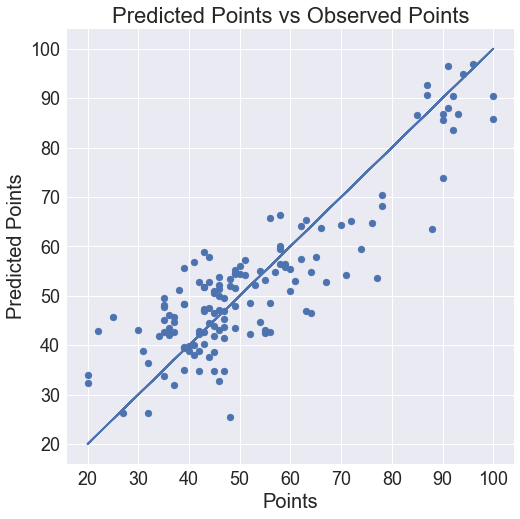

In [60]:
#plot predicted points vs observed points
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(x = y, y = model.predict(X))
ax.plot( y, y );

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.set_xlabel('Points', fontsize = 20)
ax.set_ylabel('Predicted Points', fontsize = 20)
ax.set_title('Predicted Points vs Observed Points', fontsize = 22);


In [61]:
#make coefficient dataframe
coefficient = pd.DataFrame(columns = ['feature', 'coefficient'])
coefficient['feature'] = Points_Statistics_df_final.columns[1:]
coefficient['coefficient'] = fit_final.coef_
coefficient = coefficient.sort_values('coefficient', ascending = False).reset_index(drop = True)
coefficient

,feature,coefficient
0,shots_ot_pg,11.699933
1,pass_success,2.674173
2,tackles_pg,1.585826
3,aerials_won,1.100006
4,offsides_pg,0.925908
5,dribbles_pg,0.059670
6,fouls_pg,0.035613
7,discipline_yellow,-0.666102
8,discipline_red,-1.909797
9,shots_pg,-2.350719


In [62]:
fit_final.intercept_

52.600000000000001

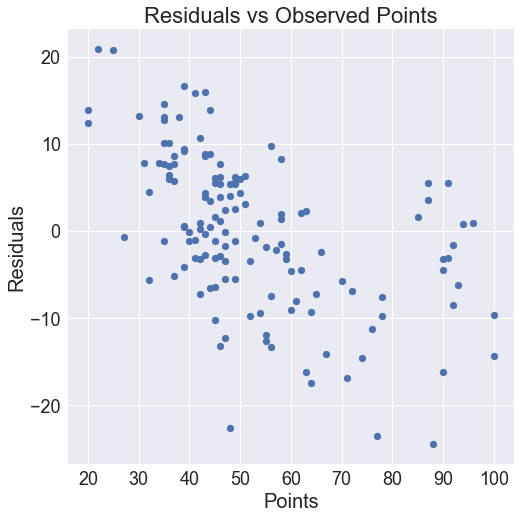

In [64]:
#visualize residuals vs points
fig1, ax1 = plt.subplots(figsize = (8, 8))
plt.scatter(y, model.predict(X)-y );

ax1.set_xlabel('Points', fontsize = 20)
ax1.set_ylabel('Residuals', fontsize = 20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax1.set_title('Residuals vs Observed Points', fontsize = 22);

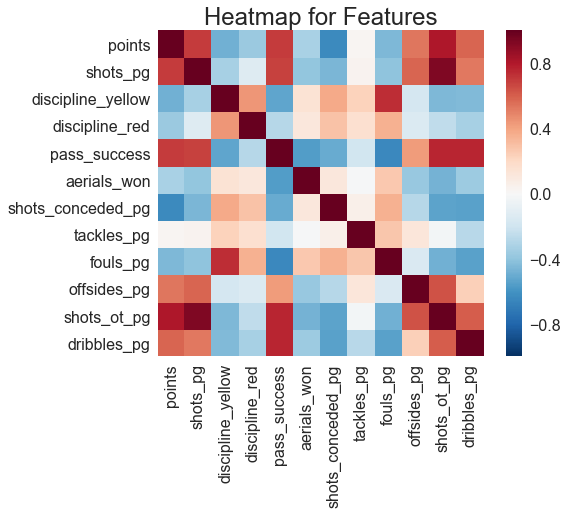

In [76]:
#plot heatmap for all the features
fig2, ax2 = plt.subplots(figsize = (8,6))
rc={'axes.labelsize': 16, 'font.size': 16, 'legend.fontsize': 32.0, 'axes.titlesize': 24, 'xtick.labelsize': 16, 'ytick.labelsize': 16}
sns.set(rc = rc)
sns.heatmap(Points_Statistics_df_final.corr(),square=True,ax = ax2)
ax2.set_title('Heatmap for Features');

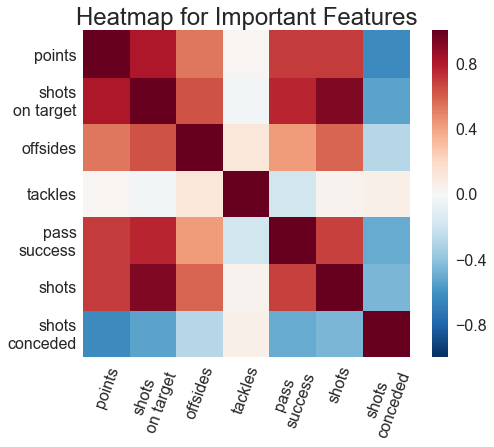

In [79]:
#plot heatmap for important features
fig3, ax3 = plt.subplots(figsize = (8,6))
sns.heatmap(Points_Statistics_df[['points', 'shots_ot_pg', 'offsides_pg', 'tackles_pg','pass_success', 'shots_pg', 'shots_conceded_pg']].corr(),square=True, ax = ax3);
plt.xticks(rotation=70);
ax3.set_yticklabels(['shots\nconceded', 'shots', 'pass\nsuccess', 'tackles', 'offsides', 'shots\non target', 'points']);
ax3.set_xticklabels(['points', 'shots\non target', 'offsides', 'tackles','pass\nsuccess', 'shots', 'shots\nconceded'])
ax3.set_title('Heatmap for Important Features');